In [1]:
import os
os.environ["MKL_NUM_THREADS"]="16" 
os.environ["NUMEXPR_NUM_THREADS"]='16'
os.environ["OMP_NUM_THREADS"]='16'
import matplotlib.pyplot as plt
import types
import numpy as np
from tqdm import notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim

%matplotlib inline

from importlib import reload


import Generators, Features, Data, Likelihoods

import KernelWakeSleep as kws

device = torch.device("cuda:0")
reload(Data)

<module 'Data' from '/nfs/ghome/live/kevinli/Code/kws/Data.py'>

In [22]:
from VPL import Gabor

def gen_gabors(image_size,n, theta=None):
    
    grid = torch.linspace(-1,1,image_size)
    xy = torch.rand(n,2)*1.-0.5
    if theta is None:
        theta_phi = torch.rand(n,2)*np.pi
    else:
        theta_phi = theta
    imgs =[]
    for i in range(n):
        imgs += Gabor(grid, theta_phi[i,0], xy[i]*0, 1, phi=theta_phi[i,1]*0, gamma_infer=0.8, lambda_=1.0, sigma=0.3),
        
    imgs = torch.stack(imgs)
    imgs = imgs + torch.randn(*imgs.shape)*0.0
    return imgs

ntrain = 10000
image_size = 16
batch_size = 100

train_images = gen_gabors(image_size,ntrain).reshape(ntrain, -1)
test_images = gen_gabors(image_size,ntrain//10).reshape(ntrain//10, -1)

In [23]:
class gabor_prior(object):
    
    def __init__(self,):
        
        pass
    
    def transform_angle(self, a):
        
        return torch.cat([torch.stack([torch.sin(a[:,i]), torch.cos(a[:,i])],-1) for i in range(a.shape[-1])],-1)
    
#     def transform_angle(self, a):
#         return torch.stack([torch.sin(a[:,0]), torch.cos(a[:,0])*torch.sin(a[:,1]),  torch.cos(a[:,1])*torch.sin(a[:,2])],-1)
    
    def sample(self, shape):
        n = shape[0]
        xy = torch.rand(n,2)*2-1
        theta_phi = torch.rand(n,1)*2*np.pi - np.pi
        sc = self.transform_angle(theta_phi)
        return sc.to(device)
    
   
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_images),
    batch_size=batch_size, shuffle=True)

    

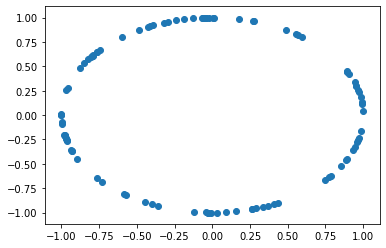

In [24]:
prior = gabor_prior()
z = prior.sample([100]).cpu().numpy()
plt.scatter(*z.T)


In [25]:
batch_size = 100
nc = 1


nsleep = 2000
nepoch = 10
nvalid = 2000

Dx = test_images.shape[-1]
image_size = int(np.sqrt(Dx//nc))
image_size

16

In [26]:
reload(Generators)
reload(Features)
reload(Likelihoods)

<module 'Likelihoods' from '/nfs/ghome/live/kevinli/Code/kws/Likelihoods.py'>

In [27]:
import torch.nn as nn

def dc_gen(nz=100, ngf=64, nc=1, bn=False, tanh=False, sigmoid=False):
    layers = \
        [
        # input is Z, going into a convolution
        nn.ConvTranspose2d(     nz, ngf * 4, 4, 1, 0, bias=True),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        ]


    return nn.Sequential(*layers)


In [28]:
D0 = 2
log_noise = torch.tensor(0.0, device=device, requires_grad=True)
gen_network    = dc_gen(nz=D0, tanh=True).to(device)
obs   = Likelihoods.GaussianObservation(gen_network, log_noise)

nnet = 3
block_size=100

data = kws.draw_sample(prior, obs, nsleep)

kernel_networks = []
Fdata = []
for i in range(nnet):
    k = Features.lin_feat(Dx, block_size, bn=True).to(device)
#     k = Features.dc_feat(image_size,ngf, nfinal=100, bn=False, nl=True, nc=nc).to(device)
    k.apply(kws.weights_init)
    Fdata += k(data),
    kernel_networks += k,

Fdata   = torch.cat(Fdata, -1) 
Fmedian =  kws.estimate_median_distance(Fdata)
kernel = kws.Kernel(kernel_networks, Fmedian, lam=1e-2, train_sigma=True, train_lam=True).to(device)

In [29]:
optimizer = optim.Adam(list(gen_network.parameters())+[log_noise], lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
network_grad_norms = []

feat_mmds = []
recons = []

In [46]:
import gc
gc.collect()

gen_network.train()
kernel.train()

for ei in notebook.tqdm(range(300)):
    
    with notebook.tqdm(train_loader, leave=False) as t:
        for i, (X_tr,) in enumerate(t):
        
            X_tr = X_tr.float().to(device)

            
            for j in range(1):
                

                data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
                data_0_val, data_1_val, norm_val, nat_val = kws.sleep(prior, obs, nsleep//10, detach=True)
                S_val = obs.suff(data_1_val)
                
                kernel_optimizer.zero_grad()


                # Elogp_val = KRR_old(obs.suff,deep_gaussian_gram, data_1_val, data_1, norm.detach(), nat.detach(), 
                #                 log_sigma, log_lam, noise = 0.0*binary)
                Elogp_val = kws.KRR_2(obs.suff, kernel, data_1_val, data_1, norm, nat)

                loss_val = torch.mean((Elogp_val + norm_val - (nat_val * S_val).sum(-1))**2)

                kernel_network_norm = sum([sum(
                                            map(lambda x: (x**2).sum(), k.parameters())
                                                )
                                           for k in kernel_networks])
                kernel_network_norms += kernel_network_norm.cpu().detach().numpy(),
                
                loss_val = loss_val

                loss_val.backward(retain_graph=False)
                
#                 for k in kernel.kernel_networks:
#                     k[1].weight.data /= k[1].weight.data.norm(2, dim=-1, keepdim=True)
#                     k[4].weight.data /= k[4].weight.data.norm(2, dim=-1, keepdim=True)
                
                kernel_optimizer.step()
                kernel_optimizer_net.step()


                log_lams += kernel.log_lam.cpu().detach().numpy(),
                log_sigmas += kernel.log_sigma.cpu().detach().numpy(),
                losses += loss_val.detach().cpu().numpy(),
                    
            data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
            
            # Elogp = KRR_old(obs.suff,deep_gaussian_gram, X_tr, data_1, norm, nat, log_sigma, log_lam)
            Elogp  = kws.KRR_2(obs.suff, kernel, X_tr, data_1, norm, nat).mean()
            
            
            network_norm = sum(map(lambda x: (x**2).sum(), gen_network.parameters()))
            network_norms += network_norm,    
            
            gen_loss = -Elogp
            
            t.set_postfix(Elogp=Elogp.item())

            Elogps += Elogp.detach().cpu().numpy(),

            optimizer.zero_grad()
            gen_loss.backward(retain_graph=False)
                        
            network_norm = sum(map(lambda x: (x**2).sum(), gen_network.parameters()))
            network_norms += network_norm,
            network_grad_norm = sum(map(lambda x: (x.grad**2).sum(), gen_network.parameters()))
            network_grad_norms += network_grad_norm,

            optimizer.step()

            noise_stds += obs.log_std.exp().detach().cpu().numpy(),

KeyboardInterrupt: 

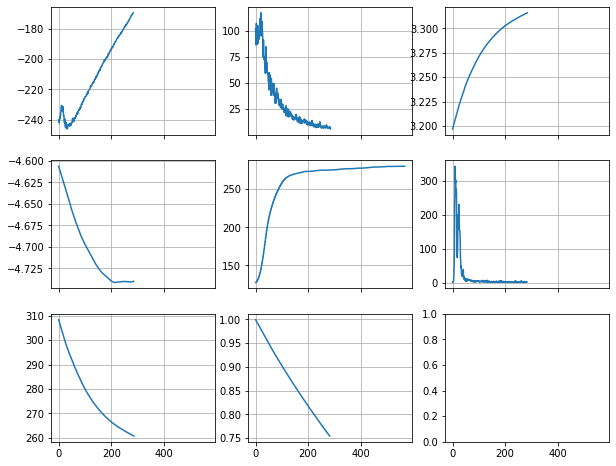

In [47]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          kernel_network_norms, noise_stds]


nplot = len(params)
fig, axes = plt.subplots(3,nplot//3+1, figsize=(10,8), sharex=True)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

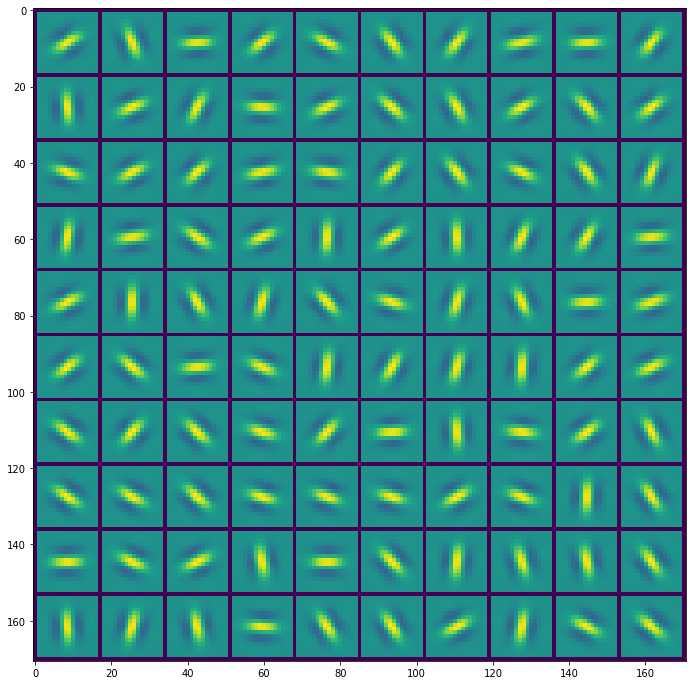

In [48]:
from scipy.stats import norm
from itertools import product
import torchvision

nz = 10
margin = 0.01
z = prior.sample([nz**2])

x = obs.conditional_param(z).mean.detach().cpu()

plt.figure(figsize=(12,12))
img = torchvision.utils.make_grid(x[:nz**2].reshape(nz**2,1,image_size, image_size), nz, padding=1, pad_value=-1)
plt.imshow(img[0])

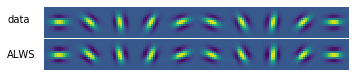

In [66]:
from scipy.stats import norm
from itertools import product
import torchvision

nz = 10
margin = 0.01
# z = torch.tensor(list(product(zgrid, zgrid))).to(device)

z = torch.zeros(nz,D0).cuda()
offset =-1.4
angles = torch.linspace(2*np.pi+offset, -2*np.pi+offset, nz)[:,None]
z[:,-2:] = prior.transform_angle(angles)

x = obs.conditional_param(z).mean.detach().cpu()

fig, ax = plt.subplots(figsize=(5,3))
img = torchvision.utils.make_grid(x[:nz**2].reshape(nz,1,image_size, image_size), nz, padding=0, pad_value=-1)

offset = np.pi/2
angles = torch.linspace(-np.pi+offset, np.pi+offset, nz)[:,None]
x = gen_gabors(16,nz,angles.expand(10,2))
img_real = torchvision.utils.make_grid(x[:nz**2].reshape(nz,1,image_size, image_size), nz, padding=0, pad_value=-1)

plt.imshow(torch.cat([img_real[0], 
                      torch.full((1,160), np.nan),
                      img[0]]))
ax.text(-20,8,"data")
ax.text(-20,26,"ALWS")


ax.set_axis_off()
fig.tight_layout()
# fig.savefig("figs/gabors.pdf",  bbox_inches='tight', pad_inches=0.01)